# Install Requirements

In [87]:
!pip install googletrans==4.0.0-rc1 networkx matplotlib html2text Mastodon.py

#Import Libraries

In [88]:
import networkx as nx
import matplotlib.pyplot as plt
import os
from mastodon import Mastodon
import networkx as nx
from datetime import datetime
import json
import html2text
import re
from urllib.parse import urlparse
from googletrans import Translator
import random

#GRAPH FUNCTIONS

In [89]:

# GET THE FOLLOWERS OF A USER
def get_followers(mastodon, user_id):
    followers = mastodon.account_followers(user_id)
    follower_ids = {follower.id for follower in followers}
    return follower_ids

# GET THE FOLLOWEES OF A USER
def get_followees(mastodon, user_id):
    followees = mastodon.account_following(user_id)
    followee_ids = {followee.id for followee in followees}
    return followee_ids

# CREATE A FRIENDSHIP NETWORK
def create_friendship_network(G, data_list, mastodon):
    user_ids = set(user['account_id'] for user in data_list)

    for user_id in user_ids:
        G.add_node(user_id, label=user_id)  # ADD A NODE FOR EACH USER

    for user in data_list:
        user_id = user['account_id']
        followers = get_followers(mastodon, user_id)
        followees = get_followees(mastodon, user_id)

        if followers and followees:
            for follower_id in followers:
                if (follower_id in user_ids) and (not G.has_edge(follower_id, user_id)):
                    G.add_edge(user_id, follower_id)  # ADD AN EDGE FOR EACH FOLLOWER

            for followee_id in followees:
                if (followee_id in user_ids) and (not G.has_edge(follower_id, user_id)):
                    G.add_edge(user_id, followee_id)  # ADD AN EDGE FOR EACH FOLLOWEE

    return G

# CREATE A GRAPH
def create_graph(G, followers, followees):
    # ADD NODES FOR FOLLOWERS AND FOLLOWEES
    for user in followers:
        G.add_node(user["account_id"], label=user["username"], type="follower")

    for user in followees:
        G.add_node(user["account_id"], label=user["username"], type="followee")

    # ADD EDGES TO REPRESENT RELATIONSHIPS (FOLLOWS)
    for user in followers:
        for followee in followees:
            G.add_edge(user["account_id"], followee["id"])

# VISUALIZE THE GRAPH
def visualize_graph(G, color="skyblue"):
    pos = nx.spring_layout(G, seed=42, color=color)
    labels = nx.get_node_attributes(G, "label")
    nx.draw(G, pos, with_labels=True, node_size=10, labels=labels, node_color=color, font_size=6)
    plt.title("Friendship Network")
    plt.show()

def has_edge(G, node1, node2):
  return G.has_edge(node1, node2)


# MASTODON FUNCTIONS

In [90]:


# REGULAR EXPRESSION PATTERN TO MATCH URLS
url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

# CUSTOM JSON ENCODER FOR DATETIME OBJECTS
class DateTimeEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, datetime):
            return obj.isoformat()
        return super().default(obj)

# CLASS TO REPRESENT A MASTODON TOOT (POST)
class MastodonToot:
    def __init__(self, data):
        self.id = data.get('id', None)
        self.account_id = data['account']['id'] if 'account' in data and 'id' in data['account'] else None

        # PREPROCESSING FUNCTIONS TO CLEAN AND TRANSLATE TEXT CONTENT
        accountNoteContent = self.preProcessStr(data['account']['note']) if 'account' in data and 'note' in data['account'] else None
        nonHTMLContent = self.preProcessStr(data.get('content', ''))

        if data.get('language') == 'en':
            self.content = nonHTMLContent
            self.account_note = accountNoteContent
        else:
            try:
                self.content = self.get_en_version(nonHTMLContent)
                self.account_note = self.get_en_version(accountNoteContent)
            except Exception as e:
                print(f"Translation error: {e}")
                self.content = None  # SET CONTENT TO NONE ON EXCEPTION
                self.account_note = None  # SET ACCOUNT_NOTE TO NONE ON EXCEPTION

    def preProcessStr(self, input_str):
        # REMOVE URLS AND CLEANUP THE TEXT
        return self.remove_urls(self.parse_html_content(input_str).replace(r'\n',''))

    def get_en_version(self, text_to_translate):
        # TRANSLATE TEXT TO ENGLISH
        translator = Translator()
        target_language = "en"
        return translator.translate(text_to_translate, dest=target_language).text

    def parse_html_content(self, html_content):
        # REMOVE HTML TAGS AND UNESCAPE HTML ENTITIES
        h = html2text.HTML2Text()
        h.ignore_links = True
        return h.handle(html_content)

    def to_dict(self):
        # CONVERT THE MASTODONTOOT OBJECT TO A DICTIONARY
        return {
            'id': self.id,
            'account_id': self.account_id,
            'account_note': self.account_note.replace('\n', ''),
            'content': self.content.replace('\n', ''),
        }

    def remove_urls(self, text):
        # REMOVE URLS USING REGULAR EXPRESSION
        return re.sub(url_pattern, '', text)


#UTILITY FUNCTIONS

In [91]:

# FUNCTION TO PARSE A LIST OF TOOTS (POSTS)
def parse_toots(data_list):
    return [MastodonToot(data) for data in data_list]

# FUNCTION TO EXTRACT USER IDS FROM A LIST OF TOOTS
def get_user_ids(data_list):
    user_ids = []
    for user in data_list:
        user_ids.append(user.account_id)
    return user_ids

# FUNCTION TO STORE TOOTS (POSTS) INTO A JSON FILE
def store_to_json(filename, toots):
    with open(filename, 'w', encoding='utf-8') as json_file:
        json.dump([vars(toot) for toot in toots], json_file, ensure_ascii=False, indent=4, cls=DateTimeEncoder)

# FUNCTION TO READ DATA FROM A JSON FILE
def read_data_from_JSON(file_path):
    with open(file_path, 'r', encoding='utf-8') as json_file:
        json_data = json.load(json_file)
    return json_data



# Mastodon Configs

In [92]:
MASTODON_CLIENT_KEY = "SfdaXTphy0Iv9GI3S7kZSjebWZj-KAAIVd9wanzLgS0"
MASTODON_CLIENT_SECRET = "-MeoT7e-p1pRyVE7X06Ikg6WOj7s1BiyvLdDKsMuC30"
MASTODON_ACCESS_TOKEN = "nkENC6AiSOg6eUlz4VttQZ4iXgBBgP6ev70rlkIQm2o"
MASTODON_APP_NAME = "DataCrawler"
MASTODON_BASE_URL = "https://mastodon.social"

In [93]:


# INITIALIZE MASTODON CLIENT WITH CREDENTIALS
mastodon = Mastodon(
    client_id=MASTODON_CLIENT_KEY,
    client_secret=MASTODON_CLIENT_SECRET,
    access_token=MASTODON_ACCESS_TOKEN,
    api_base_url=MASTODON_BASE_URL
)

# LIST OF CONTROVERSIAL HASHTAGS TO SEARCH FOR
controversial_hashtags = [
    'canada',
    'india',
    'contraversy'
]

# LIST TO STORE FINAL TOOTS
Finaltoots = []

# FUNCTION TO FETCH DATA FROM THE MASTODON API
def fetch_data_from_API():

    for hashtag in controversial_hashtags:
        toots = []
        limit = 500

        # FETCH INITIAL TOOTS FOR THE HASHTAG
        result = mastodon.timeline_hashtag(hashtag)
        if len(result):
            toots.extend(parse_toots(result))
            page_next = None

            # FETCH ADDITIONAL PAGES OF TOOTS IF AVAILABLE
            while True:
                page_next = mastodon.fetch_next(result)
                if page_next == result or not page_next:
                    break
                toots.extend(parse_toots(page_next))
                result = page_next

                if len(toots) >= limit:
                    break
        Finaltoots.extend(toots)

    return Finaltoots


In [94]:
if not os.path.exists('toots_300.json'):
    toots = fetch_data_from_API()
    store_to_json('toots_300.json', toots)



In [95]:
JSONList = read_data_from_JSON('toots_300.json')
print(len(JSONList))

1001


In [96]:


# DEFINE THE NAME OF THE GRAPH FILE
graphName = "my_graph_300.graphml"

# CHECK IF THE GRAPH FILE EXISTS
if os.path.exists(graphName):
    # LOAD THE GRAPH FROM THE EXISTING FILE
    original_graph = nx.read_graphml(graphName)
    print("Graph loaded successfully.")
else:
    # CREATE A NEW GRAPH IF THE FILE DOESN'T EXIST
    original_graph = nx.Graph()

    # CREATE A FRIENDSHIP NETWORK USING CREATE_FRIENDSHIP_NETWORK FUNCTION (NOT SHOWN IN THE PROVIDED CODE SNIPPET)
    create_friendship_network(original_graph, JSONList, mastodon)

    # WRITE THE NEW GRAPH TO THE GRAPHML FILE
    nx.write_graphml(original_graph, "my_graph_300.graphml")



Graph loaded successfully.


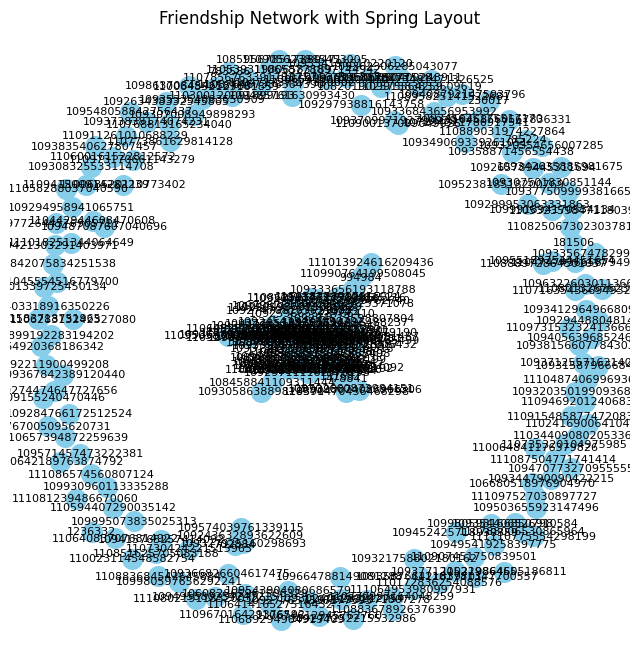

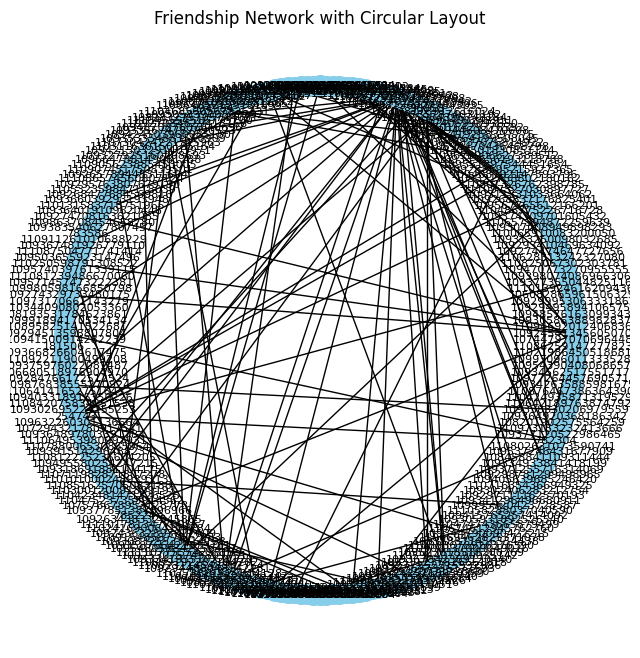

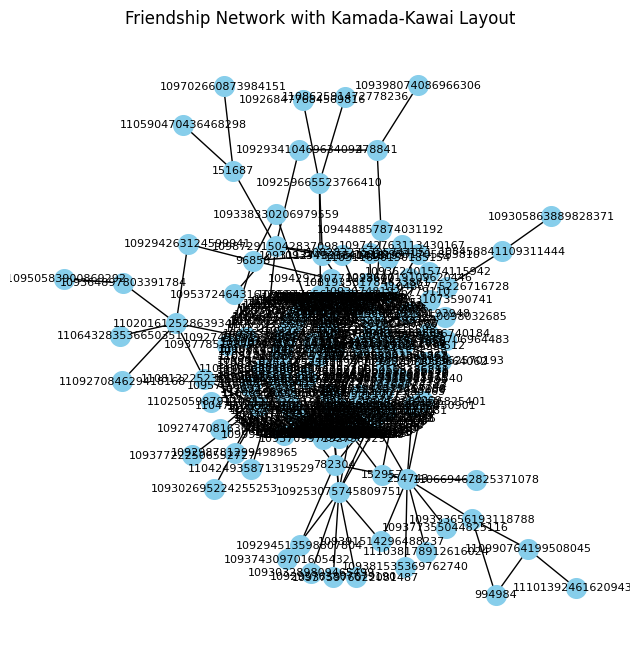

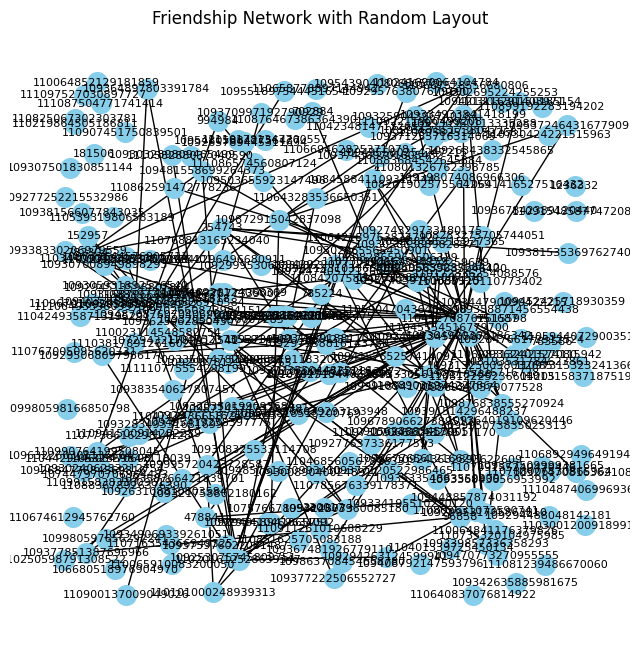

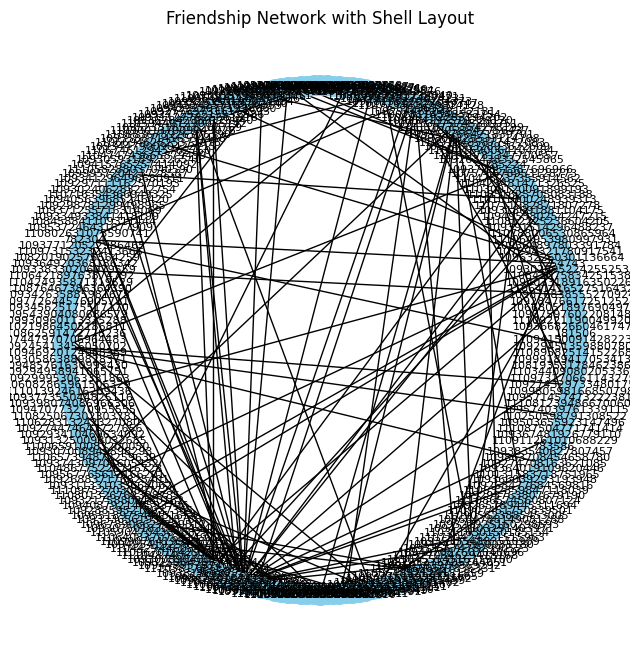

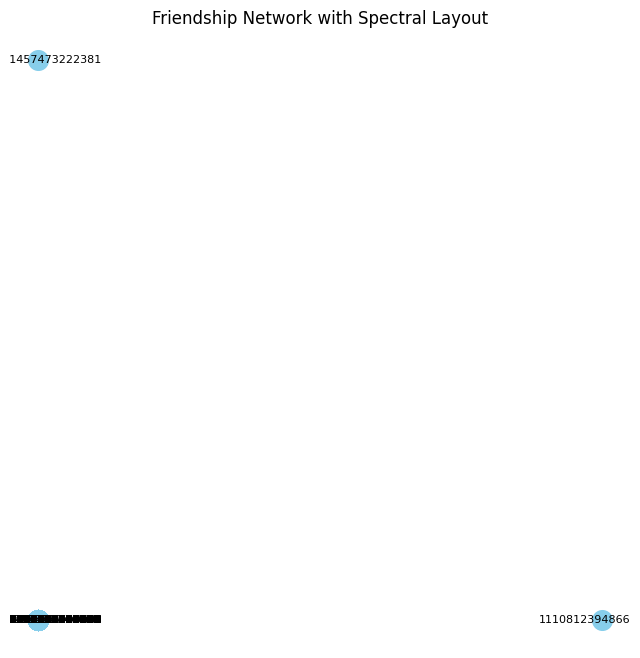

In [97]:

# Layouts
layouts = {
    "Spring Layout": nx.spring_layout(original_graph),
    "Circular Layout": nx.circular_layout(original_graph),
    "Kamada-Kawai Layout": nx.kamada_kawai_layout(original_graph),
    "Random Layout": nx.random_layout(original_graph),
    "Shell Layout": nx.shell_layout(original_graph),
    "Spectral Layout": nx.spectral_layout(original_graph),
}

# Visualize the graph using different layouts
for layout_name, pos in layouts.items():
    plt.figure(figsize=(8, 8))
    plt.title(f"Friendship Network with {layout_name}")
    nx.draw(original_graph, pos, with_labels=True, node_size=200, node_color="skyblue", font_size=8)
    plt.show()


#LLM

In [98]:
!pip install -q datasets loralib sentencepiece
!pip uninstall transformers -y
!pip install -q git+https://github.com/zphang/transformers@c3dc391
!pip -q install git+https://github.com/huggingface/peft.git
!pip -q install bitsandbytes

Found existing installation: transformers 4.27.0.dev0
Uninstalling transformers-4.27.0.dev0:
  Successfully uninstalled transformers-4.27.0.dev0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [99]:
from peft import PeftModel
from transformers import LLaMATokenizer, LLaMAForCausalLM, GenerationConfig
import textwrap

In [100]:
tokenizer = LLaMATokenizer.from_pretrained("decapoda-research/llama-7b-hf")

model = LLaMAForCausalLM.from_pretrained(
    "decapoda-research/llama-7b-hf",
    load_in_8bit=True,
    device_map="auto",
)
model = PeftModel.from_pretrained(model, "samwit/alpaca7B-lora")

Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable model loading in mixed int8. Either pass torch_dtype=torch.float16 or don't pass this argument at all to remove this warning.


ValueError: ignored

#Plotting Graphs

In [104]:
def alpaca_talk(text):
    # TOKENIZE THE INPUT TEXT
    inputs = tokenizer(
        text,
        return_tensors="pt",
    )
    # MOVE INPUT TENSORS TO GPU (IF AVAILABLE)
    input_ids = inputs["input_ids"].cuda()

    # CONFIGURE GENERATION PARAMETERS
    generation_config = GenerationConfig(
        temperature=0.6,
        top_p=0.95,
        repetition_penalty=1.2,
    )

    generated_output = []  # STORE GENERATED OUTPUTS

    # GENERATE TEXT USING THE MODEL
    generation_output = model.generate(
        input_ids=input_ids,
        generation_config=generation_config,
        return_dict_in_generate=True,
        output_scores=True,
        max_new_tokens=256,
    )

    # PROCESS EACH GENERATED SEQUENCE
    for s in generation_output.sequences:
        generated_output.append(tokenizer.decode(s))

    # EXTRACT THE ANSWER FROM GENERATED OUTPUT
    answerFromLLM = "".join(generated_output).split('### Response:')[1]

    # CHECK IF THE GENERATED ANSWER CONTAINS 'PRO', 'ANTI', OR NEITHER
    if 'pro' in answerFromLLM.lower():
        return 'pro'
    elif 'anti' in answerFromLLM.lower():
        return 'anti'
    else:
        return 'neutral'


In [105]:
prompt = """
'''Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
By analyzing input in the following format:
'''
post by the user: {}
'''
Please classify this user's post sentiment as either
1. pro
2.Neutral or
3. Anti
based on their post by the user.
Give only ONE WORD answer.


for example:
```
post by the user: Gouvernement of Canada: 16 new projects in production at the National Film\nBoard of Canada. Upcoming feature documentaries and auteur animation from NFB\nstudios across Canada. \nboard/news/2023/09/16-new-projects-in-production-at-the-national-film-board-\nof-canada-upcoming-feature-documentaries-and-auteur-animation-from-nfb-\nstudios-across-canada.html #Gouvernment #Canada #newsreleases\n\n
Response: Pro
```

```
post by the user: India stopped releasing visas to Canadian citizens and urged\nCanada to reduce its diplomatic staff after the accusations of the first\nMinister Justin #trudeau of suspicious involvement of the Indian government\nIn the killing of the Canadian citizen Hardeep Singh Nijjar.\n\n@Oxybservatorioesteri",
Response: Anti
```


### Response:

"""

In [106]:
classified_nodes = []  # STORE CLASSIFIED NODES
cnt = 0  # INITIALIZING A COUNTER
useCntTermination = True  # BOOLEAN FLAG TO CONTROL TERMINATION BASED ON COUNT
LIMIT = 50  # LIMIT FOR THE NUMBER OF POSTS TO EXPLORE

if not os.path.exists('classfied_json.json'):
  # OPEN THE JSON FILE FOR APPENDING
  with open('classfied_json.json', 'a') as json_file:
      # ITERATE THROUGH JSONList
      for user in JSONList:

          if cnt == LIMIT and useCntTermination:  # CHECK IF LIMIT IS REACHED AND USE TERMINATION FLAG
              break
          account_id = user['account_id']  # GET ACCOUNT ID FROM USER DATA
          text_content = user['content']  # GET POST CONTENT FROM USER DATA
          classification = alpaca_talk(prompt.format(text_content))  # CLASSIFY THE POST
          print(f"Explored post {cnt + 1} with prediction: {classification}")  # PRINT CURRENT POST NUMBER
          user_data = {'user_id': account_id, 'classification': classification}  # CREATE USER DATA DICTIONARY

          classified_nodes.append(user_data)  # APPEND USER DATA TO CLASSIFIED NODES LIST

          # WRITE THE CURRENT USER'S DATA TO THE JSON FILE
          json.dump(user_data, json_file, indent=4)
          json_file.write('\n')  # WRITE NEWLINE CHARACTER
          cnt += 1  # INCREMENT THE COUNTER
else:
    with open('classfied_json.json', 'r') as json_file:
              classified_nodes = json.load(json_file)

In [107]:
import random

num_records_to_print = 5

random_records = random.sample(classified_nodes, num_records_to_print)

for record in random_records:
    print(record, end="\n\n")


{'user_id': 111048740699693650, 'classification': 'pro'}

{'user_id': 109298781299498965, 'classification': 'neutral'}

{'user_id': 111048740699693650, 'classification': 'neutral'}

{'user_id': 109995073835025313, 'classification': 'pro'}

{'user_id': 109274329733480175, 'classification': 'anti'}



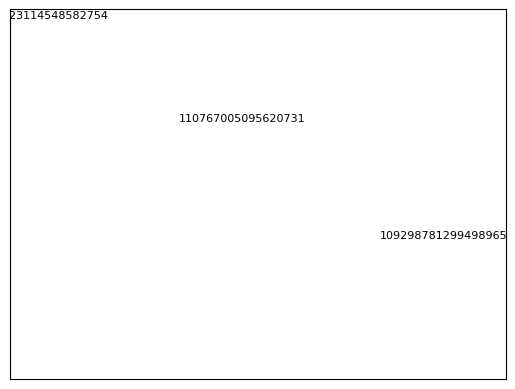

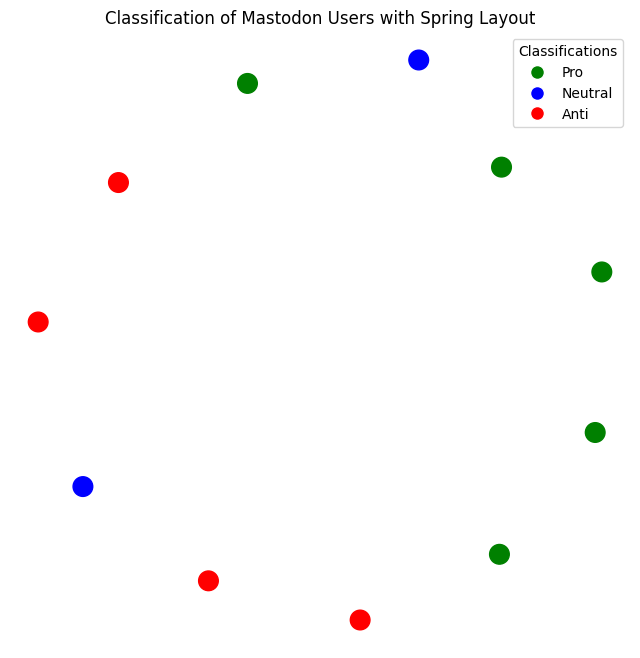

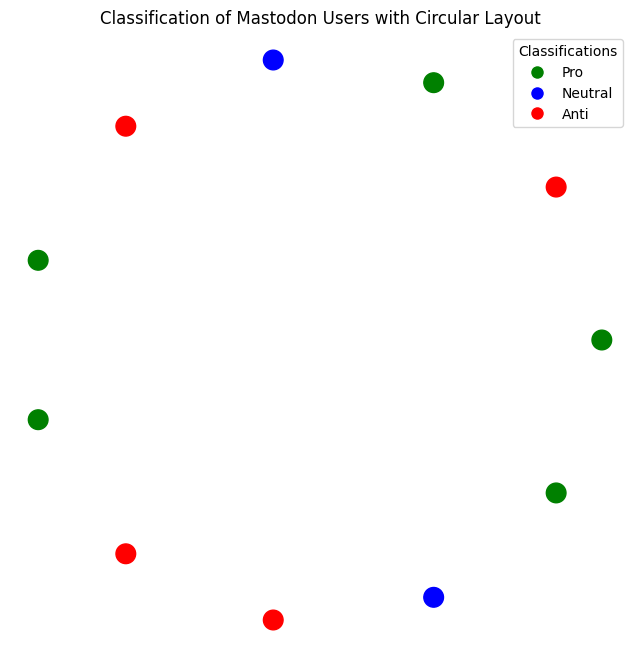

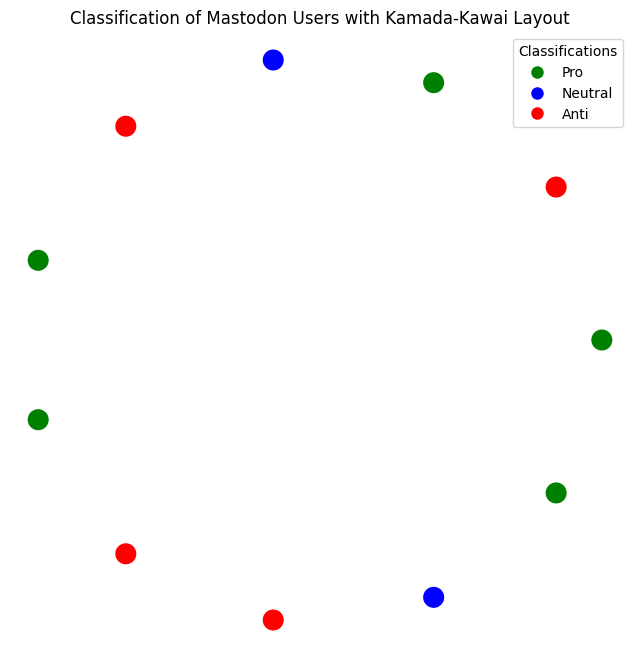

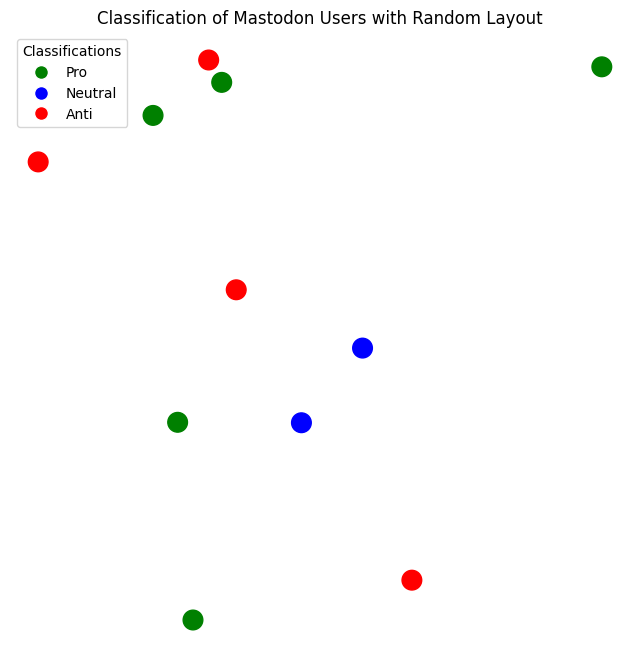

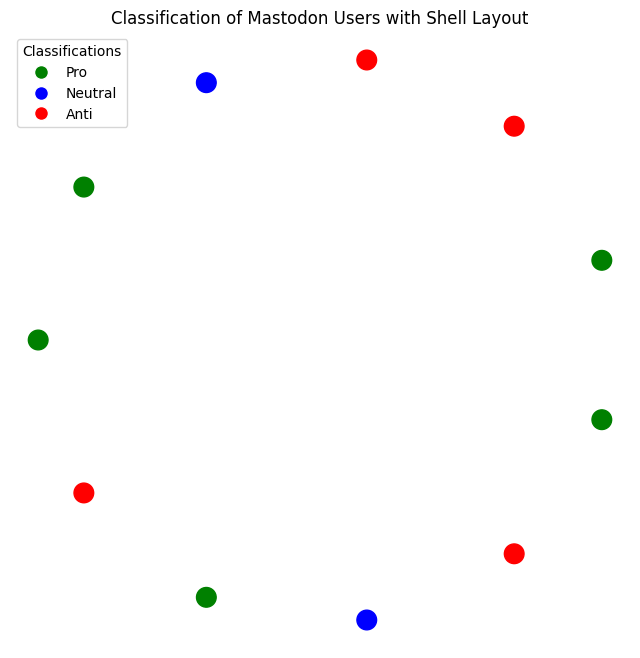

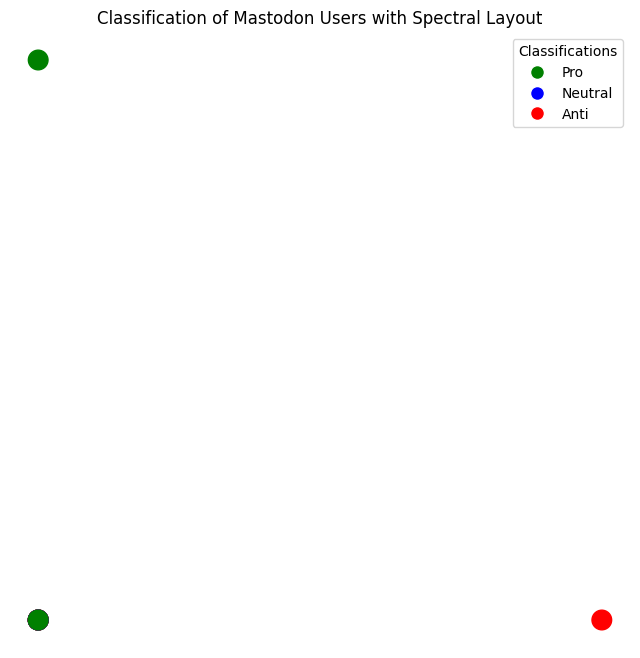

In [108]:
from matplotlib.lines import Line2D

# DEFINE THE NAME OF THE GRAPH FILE
classificationGraphName = "classification_graph_50.graphml"


# CREATE A NEW GRAPH IF THE FILE DOESN'T EXIST
classification_graph = nx.Graph()

with open('classfied_json.json', 'r') as json_file:
      classified_nodes = json.load(json_file)

# Add nodes and their classifications to the graph
for node in classified_nodes:
    user_id = node['user_id']
    classification = node['classification']
    classification_graph.add_node(user_id, classification=classification)

# Define colors based on classifications
color_map = {
    'pro': 'green',
    'neutral': 'blue',
    'anti': 'red',
}

# Get node classifications and assign colors
node_colors = [color_map[classification_graph.nodes[node]['classification']] for node in classification_graph.nodes]

# Visualize the graph with node colors
pos = nx.spring_layout(classification_graph)

# Label the nodes
labels = {node: node for node in classification_graph.nodes}
nx.draw_networkx_labels(classification_graph, pos, labels, font_size=8)

# Add edges between connected nodes
for node1 in classification_graph.nodes:
    for node2 in classification_graph.nodes:
        if node1 != node2 and has_edge(original_graph, node1, node2):
            classification_graph.add_edge(node1, node2)


# WRITE THE NEW GRAPH TO THE GRAPHML FILE
nx.write_graphml(original_graph, classificationGraphName)


# Layouts
layouts = {
    "Spring Layout": nx.spring_layout(classification_graph),
    "Circular Layout": nx.circular_layout(classification_graph),
    "Kamada-Kawai Layout": nx.kamada_kawai_layout(classification_graph),
    "Random Layout": nx.random_layout(classification_graph),
    "Shell Layout": nx.shell_layout(classification_graph),
    "Spectral Layout": nx.spectral_layout(classification_graph),
}


# Visualize the graph using different layouts
for layout_name, pos in layouts.items():
    plt.figure(figsize=(8, 8))
    plt.title(f"Classification of Mastodon Users with {layout_name}")
    nx.draw(classification_graph, pos, with_labels=False, node_size=200, node_color=node_colors, font_size=8)
    # Create a legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Pro'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Neutral'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Anti')
    ]

    plt.legend(handles=legend_elements, title='Classifications')

    plt.show()


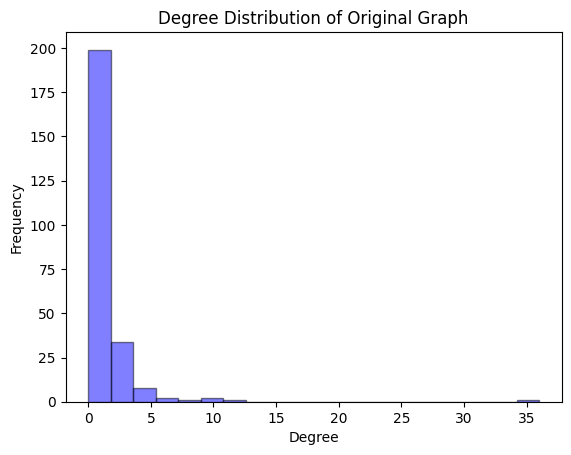

In [109]:
degrees = dict(original_graph.degree())
degree_values = list(degrees.values())

plt.hist(degree_values, bins=20, alpha=0.5, color='b', edgecolor='black')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution of Original Graph')
plt.show()


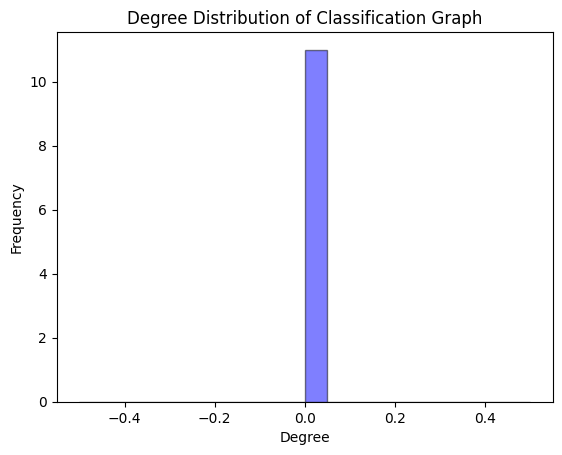

In [110]:
degrees = dict(classification_graph.degree())
degree_values = list(degrees.values())

plt.hist(degree_values, bins=20, alpha=0.5, color='b', edgecolor='black')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution of Classification Graph')
plt.show()


In [111]:
# Calculate Clustering Coefficient
clustering_coefficient = nx.clustering(original_graph)
print(f"clustering_coefficient: {clustering_coefficient}")
# Calculate Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(original_graph)
print(f"betweenness_centrality: {betweenness_centrality}")

# Calculate Closeness Centrality
closeness_centrality = nx.closeness_centrality(original_graph)
print(f"closeness_centrality: {closeness_centrality}")


clustering_coefficient: {'107447970706964483': 0, '109245413456050702': 0, '110946920124068369': 0, '109305863889828371': 0, '109485761630993430': 0, '109294958941065751': 0, '109299953063331863': 0, '106082865961506329': 0, '111013924616209436': 0, '109377355044825116': 0, '109398074086966306': 0, '109470773270955555': 0, '110825067302303781': 0, '110628313242327080': 0, '109274474647727656': 0, '109293410469634092': 0, '109313250098032685': 0, '110065910083200050': 0, '109307008949898293': 0, '110657394872259639': 0, '109374309701605432': 0, '110486775226716728': 0, '109567765612166201': 0, '109268837176825401': 0, '109311331033664062': 0, '111097527030897727': 0, '110801326762398785': 0, '109321758802180162': 0, '109408792147593796': 0, '109288595215927365': 0, '109551897544451654': 0, '109333656193118788': 0.3333333333333333, '109678906627389512': 0, '109307501830851144': 0, '110590470436468298': 0, '110640837076814922': 0, '110990764199508045': 0.3333333333333333, '109495419258397

In [112]:
# Calculate Clustering Coefficient
clustering_coefficient = nx.clustering(classification_graph)
print(f"clustering_coefficient: {clustering_coefficient}")
# Calculate Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(classification_graph)
print(f"betweenness_centrality: {betweenness_centrality}")

# Calculate Closeness Centrality
closeness_centrality = nx.closeness_centrality(classification_graph)
print(f"closeness_centrality: {closeness_centrality}")

clustering_coefficient: {110767005095620731: 0, 109274329733480175: 0, 108201902575564259: 0, 109452425718930359: 0, 109995073835025313: 0, 110023114548582754: 0, 109574039761339115: 0, 109298781299498965: 0, 110730993164048259: 0, 110895825141522681: 0, 111048740699693650: 0}
betweenness_centrality: {110767005095620731: 0.0, 109274329733480175: 0.0, 108201902575564259: 0.0, 109452425718930359: 0.0, 109995073835025313: 0.0, 110023114548582754: 0.0, 109574039761339115: 0.0, 109298781299498965: 0.0, 110730993164048259: 0.0, 110895825141522681: 0.0, 111048740699693650: 0.0}
closeness_centrality: {110767005095620731: 0.0, 109274329733480175: 0.0, 108201902575564259: 0.0, 109452425718930359: 0.0, 109995073835025313: 0.0, 110023114548582754: 0.0, 109574039761339115: 0.0, 109298781299498965: 0.0, 110730993164048259: 0.0, 110895825141522681: 0.0, 111048740699693650: 0.0}


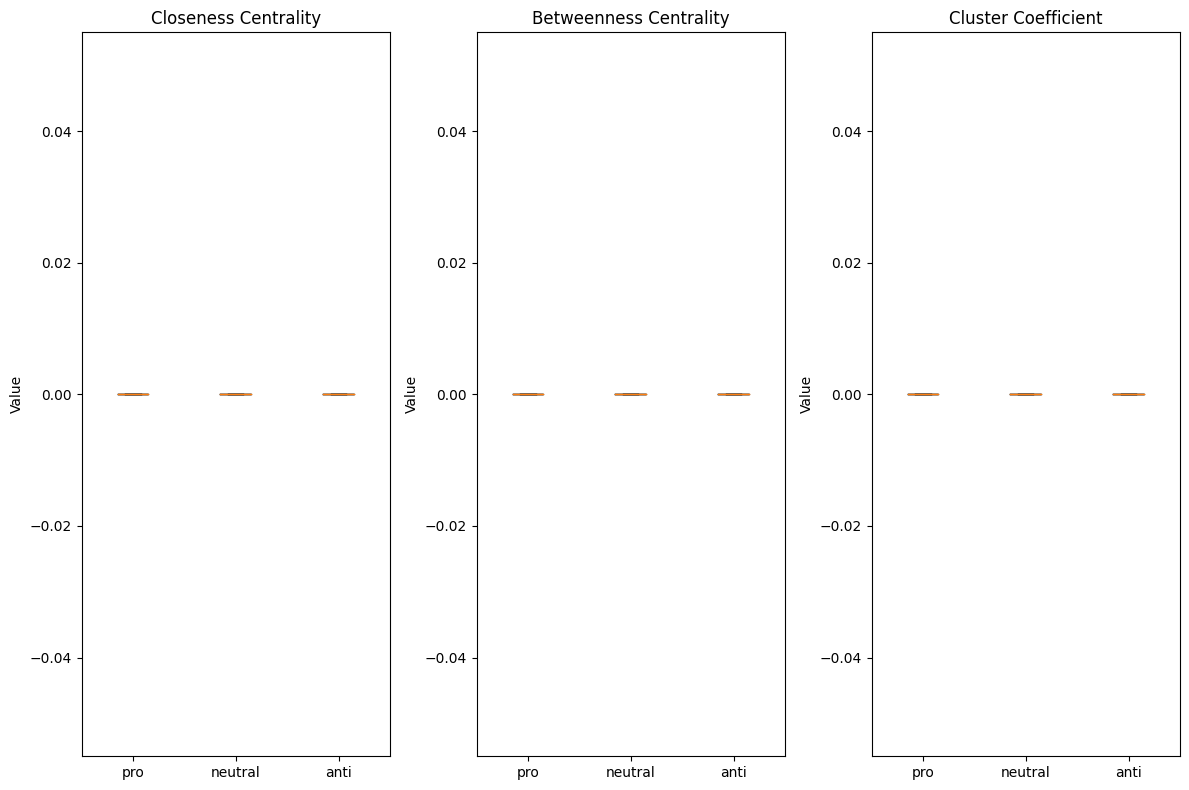

In [113]:
# Initialize dictionaries to store network measures for each classification
closeness_dict = {'pro': [], 'neutral': [], 'anti': []}
betweenness_dict = {'pro': [], 'neutral': [], 'anti': []}
cluster_coeff_dict = {'pro': [], 'neutral': [], 'anti': []}

# Iterate over nodes and calculate measures
for node in classification_graph.nodes(data=True):
    user_id = node[0]
    classification = node[1]['classification']

    # Calculate Closeness Centrality
    closeness = nx.closeness_centrality(classification_graph, u=user_id)
    closeness_dict[classification].append(closeness)

    # Calculate Betweenness Centrality
    betweenness = nx.betweenness_centrality(classification_graph, endpoints=False)[user_id]
    betweenness_dict[classification].append(betweenness)

    # Calculate Cluster Coefficient
    cluster_coeff = nx.clustering(classification_graph, nodes=user_id)
    cluster_coeff_dict[classification].append(cluster_coeff)

# Plot the distributions or single values for each measure
plt.figure(figsize=(12, 8))

# Plot Closeness Centrality
plt.subplot(131)
plt.boxplot([closeness_dict['pro'], closeness_dict['neutral'], closeness_dict['anti']], labels=['pro', 'neutral', 'anti'])
plt.title('Closeness Centrality')
plt.ylabel('Value')

# Plot Betweenness Centrality
plt.subplot(132)
plt.boxplot([betweenness_dict['pro'], betweenness_dict['neutral'], betweenness_dict['anti']], labels=['pro', 'neutral', 'anti'])
plt.title('Betweenness Centrality')
plt.ylabel('Value')

# Plot Cluster Coefficient
plt.subplot(133)
plt.boxplot([cluster_coeff_dict['pro'], cluster_coeff_dict['neutral'], cluster_coeff_dict['anti']], labels=['pro', 'neutral', 'anti'])
plt.title('Cluster Coefficient')
plt.ylabel('Value')

plt.tight_layout()
plt.show()


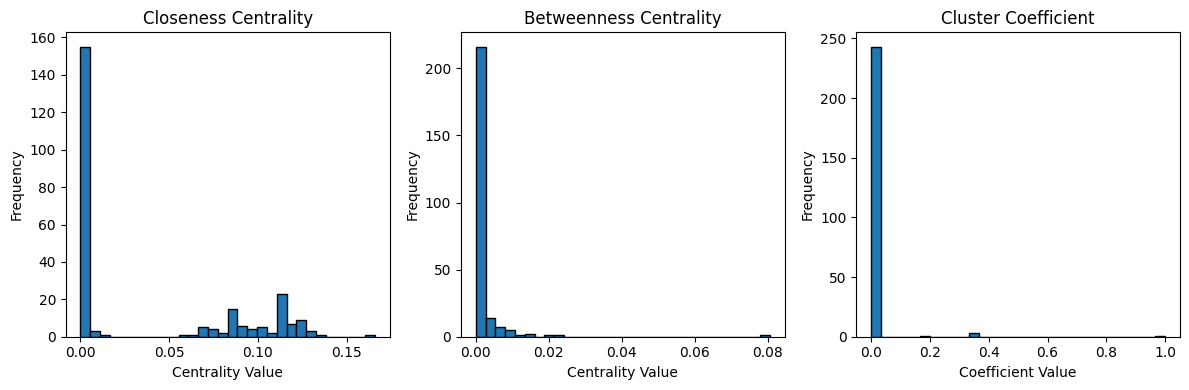

In [114]:

# Calculate Closeness Centrality for the entire graph
closeness_values = nx.closeness_centrality(original_graph)

# Calculate Betweenness Centrality for the entire graph
betweenness_values = nx.betweenness_centrality(original_graph, endpoints=False)

# Calculate Cluster Coefficient for the entire graph
cluster_coefficient_values = nx.clustering(original_graph)

# Plot Closeness Centrality
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.hist(list(closeness_values.values()), bins=30, edgecolor='black')
plt.title('Closeness Centrality')
plt.xlabel('Centrality Value')
plt.ylabel('Frequency')

# Plot Betweenness Centrality
plt.subplot(132)
plt.hist(list(betweenness_values.values()), bins=30, edgecolor='black')
plt.title('Betweenness Centrality')
plt.xlabel('Centrality Value')
plt.ylabel('Frequency')

# Plot Cluster Coefficient
plt.subplot(133)
plt.hist(list(cluster_coefficient_values.values()), bins=30, edgecolor='black')
plt.title('Cluster Coefficient')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
